In [ ]:
#----------------------------THIS CODE IS FOR GRAPHFRAMES ------------------------

from graphframes import *

interactions_df = spark.read.option("header", "true").csv('gs://msca-bdp-project-goodreads/goodreads_interactions.csv')
limit_df = interactions_df.filter(F.col('is_read')==1).select('user_id','book_id','rating')

# Calculate the minimum and maximum ratings for each user
window_spec = Window.partitionBy("user_id")
min_rating = F.min("rating").over(window_spec)
max_rating = F.max("rating").over(window_spec)

# Normalize the ratings to the range [0, 1]
normalized_ratings = (F.col("rating") - min_rating) / (max_rating - min_rating)

# Add the normalized_ratings column to your DataFrame
limit_df = limit_df.withColumn("normalized_rating", normalized_ratings)
user_vertices = limit_df.select(col("user_id").cast("int").alias("id")).distinct().withColumn("type", F.lit("user"))
book_vertices = limit_df.select(col("book_id").cast("int").alias("id")).distinct().withColumn("type", F.lit("book"))

all_vertices = user_vertices.union(book_vertices)

edges = limit_df.select(col("user_id").cast("int").alias("src"), col("book_id").cast("int").alias("dst"), "normalized_rating")

g = GraphFrame(all_vertices, edges)

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("GCS to PySpark").getOrCreate()

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-b29f4559-d67b-4cd8-b898-dd4f70a590cb;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in centra

In [3]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "path/to/your/credentials.json"

In [4]:
gcs_bucket = "gs://msca-bdp-project-goodreads"  # Replace with your GCS bucket name
data_path = f"{gcs_bucket}/goodreads_interactions.csv"

In [5]:
data_path

'gs://msca-bdp-project-goodreads/goodreads_interactions.csv'

In [5]:
df_books_csv = spark.read.csv(data_path, header=True, inferSchema=True)

In [6]:
df_books_csv.show(5)

+-------+-------+-------+------+-----------+
|user_id|book_id|is_read|rating|is_reviewed|
+-------+-------+-------+------+-----------+
|      0|    948|      1|     5|          0|
|      0|    947|      1|     5|          1|
|      0|    946|      1|     5|          0|
|      0|    945|      1|     5|          0|
|      0|    944|      1|     5|          0|
+-------+-------+-------+------+-----------+
only showing top 5 rows



In [10]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct

# Get the count of distinct user IDs
distinct_user_count = df_books_csv.select(countDistinct("user_id").alias("distinct_user_count")).collect()[0]["distinct_user_count"]

# Get the count of distinct book IDs
distinct_book_count = df_books_csv.select(countDistinct("book_id").alias("distinct_book_count")).collect()[0]["distinct_book_count"]

# Display the results
print("Count of Distinct User IDs:", distinct_user_count)
print("Count of Distinct Book IDs:", distinct_book_count)

Count of Distinct User IDs: 876145
Count of Distinct Book IDs: 2360650


In [7]:
# Specify the GCS path to the JSON file
json_data_path = f"{gcs_bucket}/goodreads_books.json"

In [8]:
# Read JSON data into a PySpark DataFrame
df_reviews_json = spark.read.json(json_data_path)

In [9]:
df_reviews_json.show(1, vertical=True)

23/11/30 20:34:18 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0------------------------------------
 asin                 |                      
 authors              | [{604031, }]         
 average_rating       | 4.00                 
 book_id              | 5333265              
 country_code         | US                   
 description          |                      
 edition_information  |                      
 format               | Paperback            
 image_url            | https://images.gr... 
 is_ebook             | false                
 isbn                 | 0312853122           
 isbn13               | 9780312853129        
 kindle_asin          |                      
 language_code        |                      
 link                 | https://www.goodr... 
 num_pages            | 256                  
 popular_shelves      | [{3, to-read}, {1... 
 publication_day      | 1                    
 publication_month    | 9                    
 publication_year     | 1984                 
 publisher            | St. Martin

In [11]:
combined_df = df_books_csv.join(df_reviews_json, "book_id", "inner")

In [12]:
combined_df.show(10)

+-------+-------+-------+------+-----------+----+------------+--------------+------------+--------------------+-------------------+---------+--------------------+--------+----------+-------------+-----------+-------------+--------------------+---------+--------------------+---------------+-----------------+----------------+--------------+-------------+------+--------------------+------------------+--------------------+--------------------+--------------------+-------+
|book_id|user_id|is_read|rating|is_reviewed|asin|     authors|average_rating|country_code|         description|edition_information|   format|           image_url|is_ebook|      isbn|       isbn13|kindle_asin|language_code|                link|num_pages|     popular_shelves|publication_day|publication_month|publication_year|     publisher|ratings_count|series|       similar_books|text_reviews_count|               title|title_without_series|                 url|work_id|
+-------+-------+-------+------+-----------+----+-----

In [13]:
combined_df.groupBy("is_reviewed").count().show()

+-----------+--------+
|is_reviewed|   count|
+-----------+--------+
|          1| 5695769|
|          0|82713179|
+-----------+--------+



In [14]:
# Specify the GCS path to the JSON file
json_data_path_2 = f"{gcs_bucket}/goodreads_reviews_dedup.json"

In [15]:
# Read JSON data into a PySpark DataFrame
df_reviews_json_2 = spark.read.json(json_data_path_2,encoding="UTF-8")

In [16]:
df_reviews_json_2.show(2,vertical=True)

-RECORD 0----------------------------
 book_id      | 24375664             
 date_added   | Fri Aug 25 13:55:... 
 date_updated | Mon Oct 09 08:55:... 
 n_comments   | 0                    
 n_votes      | 16                   
 rating       | 5                    
 read_at      | Sat Oct 07 00:00:... 
 review_id    | 5cd416f3efc3f944f... 
 review_text  | Mind blowingly co... 
 started_at   | Sat Aug 26 00:00:... 
 user_id      | 8842281e1d1347389... 
-RECORD 1----------------------------
 book_id      | 18245960             
 date_added   | Sun Jul 30 07:44:... 
 date_updated | Wed Aug 30 00:00:... 
 n_comments   | 1                    
 n_votes      | 28                   
 rating       | 5                    
 read_at      | Sat Aug 26 12:05:... 
 review_id    | dfdbb7b0eb5a7e4c2... 
 review_text  | This is a special... 
 started_at   | Tue Aug 15 13:23:... 
 user_id      | 8842281e1d1347389... 
only showing top 2 rows



In [17]:
df_reviews_json_2.show(10, vertical=True)

-RECORD 0----------------------------
 book_id      | 24375664             
 date_added   | Fri Aug 25 13:55:... 
 date_updated | Mon Oct 09 08:55:... 
 n_comments   | 0                    
 n_votes      | 16                   
 rating       | 5                    
 read_at      | Sat Oct 07 00:00:... 
 review_id    | 5cd416f3efc3f944f... 
 review_text  | Mind blowingly co... 
 started_at   | Sat Aug 26 00:00:... 
 user_id      | 8842281e1d1347389... 
-RECORD 1----------------------------
 book_id      | 18245960             
 date_added   | Sun Jul 30 07:44:... 
 date_updated | Wed Aug 30 00:00:... 
 n_comments   | 1                    
 n_votes      | 28                   
 rating       | 5                    
 read_at      | Sat Aug 26 12:05:... 
 review_id    | dfdbb7b0eb5a7e4c2... 
 review_text  | This is a special... 
 started_at   | Tue Aug 15 13:23:... 
 user_id      | 8842281e1d1347389... 
-RECORD 2----------------------------
 book_id      | 6392944              
 date_added 

In [18]:
from pyspark.sql.functions import col, when
from scipy.stats import ttest_ind

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.types import IntegerType

In [21]:
from pyspark.sql.functions import isnan, when, count

In [22]:
missing_values = df_books_csv.select([count(when(isnan(c) | df_books_csv[c].isNull(), c)).alias(c) for c in df_books_csv.columns])

In [23]:
missing_values.show(10,vertical=True)

-RECORD 0----------
 user_id     | 0   
 book_id     | 0   
 is_read     | 0   
 rating      | 0   
 is_reviewed | 0   



In [24]:
df_books_csv.selectExpr(*["sum(case when {} is null then 1 else 0 end) as {}".format(c, c) for c in df_books_csv.columns]).show()

+-------+-------+-------+------+-----------+
|user_id|book_id|is_read|rating|is_reviewed|
+-------+-------+-------+------+-----------+
|      0|      0|      0|     0|          0|
+-------+-------+-------+------+-----------+



In [25]:
null_nan_counts = df_books_csv.select([count(when(isnan(c) | (df_books_csv[c].isNull()), c)).alias(c) for c in df_books_csv.columns])

In [26]:
null_nan_counts.show(20,vertical=True)

-RECORD 0----------
 user_id     | 0   
 book_id     | 0   
 is_read     | 0   
 rating      | 0   
 is_reviewed | 0   



In [27]:
from pyspark.sql.types import IntegerType

In [28]:
df_books_csv = df_books_csv.withColumn("is_read", df_books_csv["is_read"].cast(IntegerType()))

In [29]:
duplicate_counts = df_books_csv.groupBy(df_books_csv.columns).count()

In [30]:
duplicates = duplicate_counts.filter(duplicate_counts["count"] > 1)

In [31]:
duplicates.show()

+-------+-------+-------+------+-----------+-----+
|user_id|book_id|is_read|rating|is_reviewed|count|
+-------+-------+-------+------+-----------+-----+
+-------+-------+-------+------+-----------+-----+



In [32]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("IsReadIsReviewedFilter").getOrCreate()

In [33]:
filtered_csv_df = df_books_csv.filter((df_books_csv["is_read"] == 0) & (df_books_csv["is_reviewed"] == 1))

In [34]:
filtered_csv_df.show(2,vertical=True)

-RECORD 0----------
 user_id     | 0   
 book_id     | 913 
 is_read     | 0   
 rating      | 0   
 is_reviewed | 1   
-RECORD 1----------
 user_id     | 0   
 book_id     | 910 
 is_read     | 0   
 rating      | 0   
 is_reviewed | 1   
only showing top 2 rows



In [41]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("IsReadIsReviewedFilter").getOrCreate()

filtered_csv_df = df_books_csv.filter((df_books_csv["is_read"] == 0) & (df_books_csv["is_reviewed"] == 1))
record_count = filtered_csv_df.count()
print("Number of records where is_read is 0 and is_reviewed is 1:", record_count)


Number of records where is_read is 0 and is_reviewed is 1: 283912


In [42]:
distinct_user_book_ids = df_books_csv.filter((df_books_csv.is_read == 0) & (df_books_csv.is_reviewed == 0))
distinct_user_book_ids = distinct_user_book_ids.select("user_id", "book_id").distinct()

# Show the resulting DataFrame
distinct_user_book_ids.show()


+-------+-------+
|user_id|book_id|
+-------+-------+
|  15341|  50748|
|  15341|  65822|
|  15341| 699296|
|  15341|  91608|
|  15341| 147497|
|  15341| 922364|
|  15341| 213959|
|  15341| 450314|
|  15341| 119705|
|  15341| 763853|
|  15341|  10476|
|  15341| 213715|
|  15341| 125271|
|  15341| 922253|
|  15341| 163718|
|  15341| 163712|
|  15341| 850537|
|  15341|  50588|
|  15341| 129796|
|  15341| 922175|
+-------+-------+
only showing top 20 rows



In [43]:
distinct_user_book_ids = distinct_user_book_ids.withColumn("book_id", col("book_id").cast("string"))
distinct_user_book_ids = distinct_user_book_ids.withColumn("user_id", col("user_id").cast("string"))

In [44]:
distinct_user_book_ids.show(2)

+-------+-------+
|user_id|book_id|
+-------+-------+
|  44205|   2883|
|  44207|  19083|
+-------+-------+
only showing top 2 rows



In [46]:
resulting_reviews.show(5,vertical=True)

-RECORD 0----------------------------
 book_id      | 1002783              
 date_added   | Sun Jan 29 16:26:... 
 date_updated | Mon Mar 27 10:34:... 
 n_comments   | 0                    
 n_votes      | 0                    
 rating       | 4                    
 read_at      | Wed Mar 01 00:00:... 
 review_id    | a5096d800fea406f0... 
 review_text  | Lots of useful in... 
 started_at   | Sun Jan 29 00:00:... 
 user_id      | e4c2c0760e1b57734... 
 user_id      | 428393               
 book_id      | 1002783              
-RECORD 1----------------------------
 book_id      | 1002783              
 date_added   | Sun Jan 29 16:26:... 
 date_updated | Mon Mar 27 10:34:... 
 n_comments   | 0                    
 n_votes      | 0                    
 rating       | 4                    
 read_at      | Wed Mar 01 00:00:... 
 review_id    | a5096d800fea406f0... 
 review_text  | Lots of useful in... 
 started_at   | Sun Jan 29 00:00:... 
 user_id      | e4c2c0760e1b57734... 
 user_id    

In [ ]:
distinct_user_book_ids.printSchema

In [ ]:
distinct_user_ids = filtered_csv_df.select("user_id").distinct()

In [ ]:
distinct_user_ids.show()

In [ ]:
joined_df = spark.sql("""
    SELECT r.*
    FROM df_reviews_json_2 AS r
    JOIN user_ids AS u
    ON r.user_id = u.user_id
""")

In [ ]:
joined_df.show()

In [ ]:
filtered_csv_df_2 = df_books_csv.filter((df_books_csv["is_read"] == 0) & (df_books_csv["is_reviewed"] == 0))

In [ ]:
record_count_2 = filtered_csv_df_2.count()

In [ ]:
print("Number of records where is_read is 0 and is_reviewed is 0:", record_count_2)

In [47]:
resulting_reviews2 = df_reviews_json_2.join(
    df_reviews_json,
    (df_reviews_json_2.book_id == df_reviews_json.book_id),
    "inner"
)

In [49]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

In [ ]:
df_reviews_json_2.show(5,vertical=True
                      )

In [48]:
resulting_reviews2.show(4,vertical=True)

-RECORD 0------------------------------------
 book_id              | 10000761             
 date_added           | Sat Sep 10 16:19:... 
 date_updated         | Sat Sep 10 16:33:... 
 n_comments           | 2                    
 n_votes              | 1                    
 rating               | 5                    
 read_at              | Sat Sep 10 00:00:... 
 review_id            | abae93ad132fef34f... 
 review_text          | Jason Berry has d... 
 started_at           |                      
 user_id              | 3ec16d3d84ccd6e92... 
 asin                 |                      
 authors              | [{215985, }]         
 average_rating       | 3.50                 
 book_id              | 10000761             
 country_code         | US                   
 description          | AN INVESTIGATION ... 
 edition_information  |                      
 format               | Hardcover            
 image_url            | https://images.gr... 
 is_ebook             | false     

In [50]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Define the index of the "book_id" column
column_index = 0

# Get the column by index
book_id_column = df_reviews_json_2.select(col(resulting_reviews2.columns[column_index]))

# Now, you can work with book_id_column using PySpark operations
distinct_book_id_count = book_id_column.distinct().count()

# Display the result
print("Count of Distinct Book IDs:", distinct_book_id_count)


Count of Distinct Book IDs: 2080190


In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Define the index of the "book_id" column
column_index = 0

# Get the column by index
book_id_column = df_reviews_json.select(col(resulting_reviews2.columns[column_index]))

# Now, you can work with book_id_column using PySpark operations
distinct_book_id_count = book_id_column.distinct().count()

# Display the result
print("Count of Distinct Book IDs:", distinct_book_id_count)


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct

# Get the count of distinct user IDs
distinct_user_count = resulting_reviews2.select(countDistinct("user_id").alias("distinct_user_count")).collect()[0]["distinct_user_count"]

# Get the count of distinct book IDs
#distinct_book_count = resulting_reviews2.select(countDistinct("book_id").alias("distinct_book_count")).collect()[0]["distinct_book_count"]

# Display the results
print("Count of Distinct User IDs:", distinct_user_count)
#print("Count of Distinct Book IDs:", distinct_book_count)

In [ ]:
#Checking columns-Titles and title without series have same values
resulting_reviews2_filtered = resulting_reviews2.filter(resulting_reviews2['title'] != resulting_reviews2['title_without_series'])

In [ ]:
resulting_reviews2_filtered.show(vertical=True,truncate=False)

In [ ]:
ratings_hist = df_reviews_json_2.select("rating").rdd.flatMap(lambda x: x).histogram(10)
plt.hist(ratings_hist[0], bins=ratings_hist[1], color='skyblue', edgecolor='black')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Distribution of Ratings")
plt.show()

In [ ]:
data = df_reviews_json_2.select("rating").rdd.flatMap(lambda x: x).collect()

# Create a histogram
plt.hist(data, bins=10, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel("rating")
plt.ylabel("Frequency")
plt.title(f"Histogram of rating")

# Show the plot
plt.show()



In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt


In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

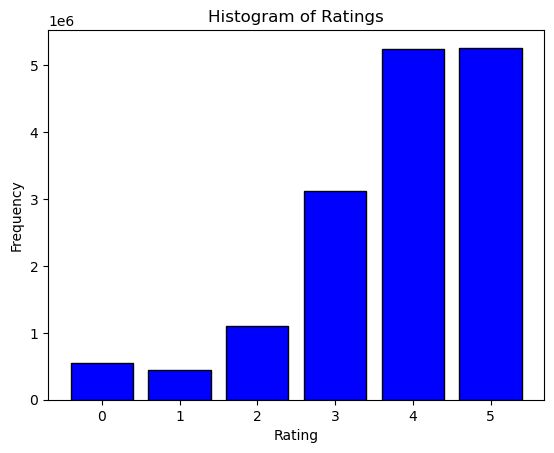

In [52]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have a DataFrame named `resulting_reviews2_filtered`, and the column is named "rating"
data = resulting_reviews2.groupBy("rating").count().orderBy("rating").collect()

# Check if there are data points
if not data:
    print("No data points to plot.")
else:
    # Extract rating and count values
    ratings = [row["rating"] for row in data]
    counts = [row["count"] for row in data]

    # Create a Pandas DataFrame
    histogram_df = pd.DataFrame({"Rating": ratings, "Count": counts})

    # Create a histogram
    plt.bar(histogram_df["Rating"], histogram_df["Count"], color='blue', edgecolor='black')

    # Add labels and title
    plt.xlabel("Rating")
    plt.ylabel("Frequency")
    plt.title("Histogram of Ratings")

    # Show the plot
    plt.show()


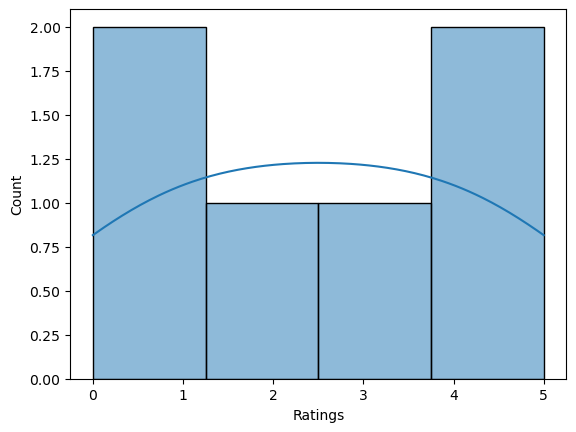

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a Pandas DataFrame named `histogram_df`
sns.histplot(data=histogram_df, x='Rating', kde=True)
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.xticks(range(6))
plt.show()


In [54]:
pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 11.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Perform sentiment analysis using a Python library like NLTK or TextBlob
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from textblob import TextBlob



In [ ]:
text_df = df_reviews_json_2.select("review_text")

In [ ]:
# Define a UDF (User Defined Function) to apply TextBlob to the DataFrame
def analyze_text(text):
    if text:
        analysis = TextBlob(text)
        return analysis.sentiment.polarity
    else:
        return 0  # Or any default value you prefer

In [ ]:
# Register the UDF
text_analysis_udf = udf(analyze_text, StringType())

In [ ]:
# Add a new column with the sentiment polarity score
result_df = text_df.withColumn("sentiment_polarity", text_analysis_udf(col("review_text")))

In [ ]:
from pyspark.sql.functions import col, udf

In [ ]:
result_df.show()

In [ ]:
pip install textblob

In [ ]:
import textblob

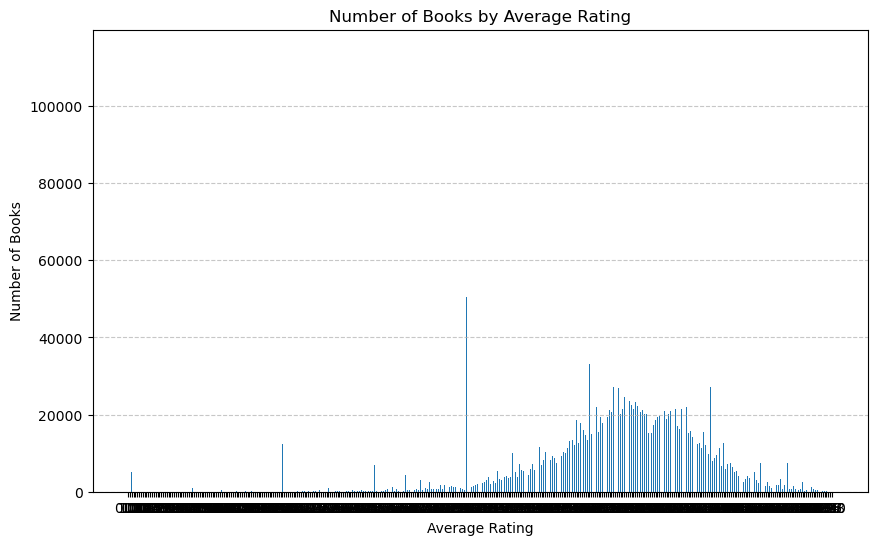

In [55]:
# Group by average_rating and count the books
ratings_count = df_reviews_json.groupBy("average_rating").count()

# Convert the result to a Pandas DataFrame for plotting
ratings_count_pd = ratings_count.toPandas()

# Sort the DataFrame by average_rating
ratings_count_pd = ratings_count_pd.sort_values(by="average_rating")

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(ratings_count_pd["average_rating"], ratings_count_pd["count"], width=0.4, align="center")
plt.xlabel("Average Rating")
plt.ylabel("Number of Books")
plt.title("Number of Books by Average Rating")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
from pyspark.sql.functions import col, desc

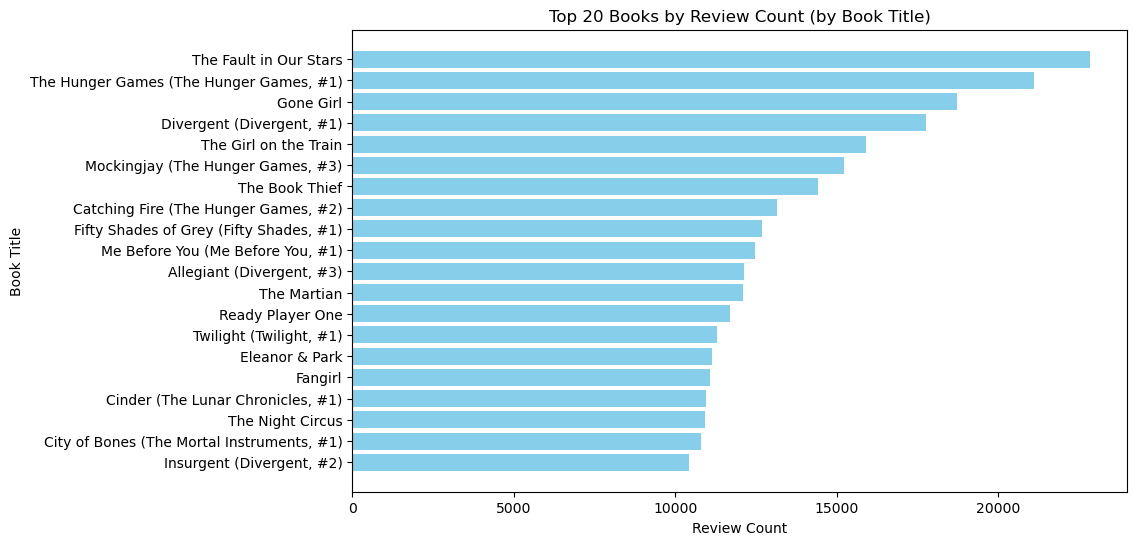

In [56]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
import matplotlib.pyplot as plt

# Group the data by book title and count the number of reviews for each book
book_counts = resulting_reviews2.groupBy("title").count()

# Sort the books by count in descending order to get the top 20 books
top_20_books = book_counts.orderBy(desc("count")).limit(20)

# Convert the result to a Pandas DataFrame for visualization
top_20_books_df = top_20_books.toPandas()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_20_books_df["title"], top_20_books_df["count"], color="skyblue")
plt.xlabel("Review Count")
plt.ylabel("Book Title")
plt.title("Top 20 Books by Review Count (by Book Title)")
plt.gca().invert_yaxis()  # Reverse the order to show the book with the most reviews at the top
plt.show()

In [57]:
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import matplotlib.pyplot as plt

# Calculate the average rating for each book
avg_ratings = resulting_reviews2.groupBy("title").agg(F.avg("rating").alias("avg_rating"))

# Create a window specification to rank books within each rating group
window_spec = Window.orderBy(F.desc("avg_rating"))

# Add a rank column to the dataframe
ranked_books = avg_ratings.withColumn("rank", F.rank().over(window_spec))

# Filter for the top 20 books
top_20_books = ranked_books.filter(ranked_books["rank"] <= 20)

# Show the results
top_20_books.show()

# Convert the result to a Pandas DataFrame for visualization
top_20_books_df = top_20_books.toPandas()

# Create a bar chart for the top 10 books with the highest average ratings
plt.figure(figsize=(10, 6))
plt.barh(top_10_books_df["title"], top_10_books_df["avg_rating"], color="skyblue")
plt.xlabel("Average Rating")
plt.ylabel("Book Title")
plt.title("Top 10 Books with Highest Average Ratings")
plt.gca().invert_yaxis()  # Reverse the order to show the book with the highest rating at the top
plt.show()

23/11/30 21:05:31 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/30 21:05:31 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/30 21:05:50 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/30 21:05:55 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/30 21:05:57 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

+--------------------+----------+----+
|               title|avg_rating|rank|
+--------------------+----------+----+
|Crafting Jewish: ...|       5.0|   1|
|In Defense of Pol...|       5.0|   1|
|Finding Sam - Par...|       5.0|   1|
|Shadowed Passage ...|       5.0|   1|
|Shadows from the ...|       5.0|   1|
|Mayor of the Rose...|       5.0|   1|
|Space Shuttle: Th...|       5.0|   1|
|Wife Of Martin Gu...|       5.0|   1|
|       All The Roads|       5.0|   1|
|Nina e la malediz...|       5.0|   1|
|Jesus and His Fri...|       5.0|   1|
|     Vlastnou hlavou|       5.0|   1|
|Forgotten Bodygua...|       5.0|   1|
|To Deserve you, A...|       5.0|   1|
|The Search for Ex...|       5.0|   1|
|Анатомия на илюзиите|       5.0|   1|
|Discovering Natur...|       5.0|   1|
|Honey So Sweet, V...|       5.0|   1|
|                Anam|       5.0|   1|
|Explore the Bible...|       5.0|   1|
+--------------------+----------+----+
only showing top 20 rows



23/11/30 21:06:15 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/30 21:06:19 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/30 21:06:22 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/30 21:06:25 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/11/30 21:06:26 WARN org.apache.spark.sql.execution.window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performanc

NameError: name 'top_10_books_df' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
pip install plotly

In [ ]:
import pandas as pd
import plotly.express as px

# Assuming you have the resulting_reviews2 DataFrame loaded
resulting_reviews2_pd = resulting_reviews2.toPandas()

# Create interactive EDA plots
fig = px.histogram(resulting_reviews2_pd, x='rating', title='Distribution of Ratings')
fig.show()

fig = px.histogram(resulting_reviews2_pd, x='num_pages', title='Distribution of Number of Pages')
fig.show()

fig = px.histogram(resulting_reviews2_pd, x='text_reviews_count', title='Distribution of Text Reviews Count')
fig.show()

fig = px.scatter(resulting_reviews2_pd, x='average_rating', y='ratings_count', title='Average Rating vs. Number of Ratings')
fig.show()

In [ ]:
resulting_reviews2.show(1,vertical=True)

In [ ]:
resulting_reviews2 = resulting_reviews2.drop(resulting_reviews2.columns[14])

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Scatter plot of average rating vs. text reviews count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=resulting_reviews2, x='average_rating', y='text_reviews_count')
plt.title('Average Rating vs. Text Reviews Count')
plt.xlabel('Average Rating')
plt.ylabel('Text Reviews Count')
plt.grid()
plt.show()

23/11/30 21:12:08 WARN org.apache.spark.storage.BlockManager: Failed to fetch block after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1069)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1013)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1013)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1151)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.sc

AnalysisException: Reference 'book_id' is ambiguous, could be: book_id, book_id.

<Figure size 1000x600 with 0 Axes>

23/11/30 21:12:15 WARN org.apache.spark.storage.BlockManager: Failed to fetch block after 1 fetch failures. Most recent failure cause:
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:301)
	at org.apache.spark.network.BlockTransferService.fetchBlockSync(BlockTransferService.scala:103)
	at org.apache.spark.storage.BlockManager.fetchRemoteManagedBuffer(BlockManager.scala:1069)
	at org.apache.spark.storage.BlockManager.$anonfun$getRemoteBlock$8(BlockManager.scala:1013)
	at scala.Option.orElse(Option.scala:447)
	at org.apache.spark.storage.BlockManager.getRemoteBlock(BlockManager.scala:1013)
	at org.apache.spark.storage.BlockManager.getRemoteBytes(BlockManager.scala:1151)
	at org.apache.spark.scheduler.TaskResultGetter$$anon$3.$anonfun$run$1(TaskResultGetter.scala:88)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.sc

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Assuming 'publication_month' and 'publication_day' are columns in your PySpark DataFrame

# Calculate the monthly and daily counts using PySpark operations
monthly_counts = resulting_reviews2.groupBy("publication_month").count().orderBy("publication_month").toPandas()
daily_counts = resulting_reviews2.groupBy("publication_day").count().orderBy("publication_day").toPandas()

# Create subplots for the plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the monthly trend
axes[0].plot(monthly_counts['publication_month'], monthly_counts['count'], marker='o', linestyle='-')
axes[0].set_title('Publication Month Trends')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Books Published')
axes[0].grid()

# Plot the daily trend
axes[1].plot(daily_counts['publication_day'], daily_counts['count'], marker='o', linestyle='-')
axes[1].set_title('Publication Day Trends')
axes[1].set_xlabel('Day of the Month')
axes[1].set_ylabel('Number of Books Published')
axes[1].grid()

plt.tight_layout()
plt.show()


In [ ]:
pip install wordcloud matplotlib

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all review texts into a single string
all_reviews_text = resulting_reviews2.selectExpr("concat_ws(' ', collect_list(review_text)) as combined_text").first()['combined_text']

# Generate the word cloud from the combined text
generate_wordcloud(all_reviews_text)

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Download NLTK data (if not already downloaded)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define a UDF (User-Defined Function) to preprocess text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords and punctuation
    stopwords_set = set(stopwords.words('english'))
    words = [word for word in words if word not in stopwords_set and word not in string.punctuation]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Rejoin the processed words to form cleaned text
    cleaned_text = ' '.join(words)
    
    return cleaned_text

# Register the UDF with Spark
preprocess_udf = udf(preprocess_text, StringType())

# Apply the UDF to the review_text column
resulting_reviews2 = resulting_reviews2.withColumn("cleaned_review_text", preprocess_udf(resulting_reviews2["review_text"]))

# Show the DataFrame with the cleaned review text
resulting_reviews2.select("review_text", "cleaned_review_text").show(truncate=False)

In [ ]:
!pip install nltk==3.6

In [ ]:
!pip install regex --upgrade

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')

In [ ]:
# Replace NLTK tokenization with whitespace-based split
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
 
    # Tokenize the text using whitespace split
    words = text.split()
 
    # Remove stopwords and punctuation
    stopwords_set = set(stopwords.words('english'))
    words = [word for word in words if word not in stopwords_set and word not in string.punctuation]
 
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
 
    # Rejoin the processed words to form cleaned text
    cleaned_text = ' '.join(words)
 
    return cleaned_text

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Download NLTK data (if not already downloaded)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Define a UDF (User-Defined Function) to preprocess text
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stopwords and punctuation
    stopwords_set = set(stopwords.words('english'))
    words = [word for word in words if word not in stopwords_set and word not in string.punctuation]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Rejoin the processed words to form cleaned text
    cleaned_text = ' '.join(words)
    
    return cleaned_text

# Register the UDF with Spark
preprocess_udf = udf(preprocess_text, StringType())

# Apply the UDF to the review_text column
resulting_reviews2 = resulting_reviews2.withColumn("cleaned_review_text", preprocess_udf(resulting_reviews2["review_text"]))

# Show the DataFrame with the cleaned review text
resulting_reviews2.select("review_text", "cleaned_review_text").show(truncate=False)

In [ ]:
import nltk
nltk.download('popular', quiet=True)

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [ ]:
from sparknlp.base import DocumentAssembler
from sparknlp.annotator import Tokenizer
from sparknlp.annotator import Normalizer
from sparknlp.annotator import LemmatizerModel


In [ ]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

# Initialize Spark NLP
spark = SparkSession.builder \
    .appName("WordCloud") \
    .getOrCreate()
sparknlp.start()

# Define a sample DataFrame with your text data
data = [("This is a sample sentence."),
        ("Another sentence to demonstrate."),
        ("You can use your DataFrame here.")]

columns = ["text"]
df = spark.createDataFrame(data, columns)

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("Scatterplot").getOrCreate()

# Extract the relevant columns
reviews_data = resulting_reviews2.select("num_pages", "text_reviews_count").dropna()

# Convert the data to Pandas for plotting
reviews_data_pandas = reviews_data.toPandas()

# Create a scatterplot using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(reviews_data_pandas["num_pages"], reviews_data_pandas["text_reviews_count"], alpha=0.5)
plt.title("Scatterplot of Number of Reviews vs. Number of Pages")
plt.xlabel("Number of Pages")
plt.ylabel("Number of Reviews")
plt.grid(True)

# Show the scatterplot
plt.show()


In [ ]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a Spark session
spark = SparkSession.builder.appName("EDA").getOrCreate()

# Assuming resulting_reviews2 is your DataFrame
# If not, you can load it from a source like CSV, Parquet, etc.

# Register the DataFrame as a temporary SQL table
resulting_reviews2.createOrReplaceTempView("reviews_table")

# Identify most popular authors based on average ratings
top_authors_query = """
    SELECT authors[0].id AS author_id, AVG(rating) AS avg_rating
    FROM reviews_table
    WHERE authors[0].id IS NOT NULL
    GROUP BY authors[0].id
    ORDER BY avg_rating DESC
    LIMIT 10
"""

# Identify most loved books based on highest average rating and most reviews
top_books_query = """
    SELECT title, AVG(rating) AS avg_rating, COUNT(*) AS review_count
    FROM reviews_table
    GROUP BY title
    HAVING COUNT(*) > 10  -- Consider books with at least 10 reviews
    ORDER BY avg_rating DESC, review_count DESC
    LIMIT 10
"""

# Run SQL queries
top_authors_df = spark.sql(top_authors_query).toPandas()
top_books_df = spark.sql(top_books_query).toPandas()

# Visualize most popular authors
plt.figure(figsize=(12, 6))
plt.bar(top_authors_df['author_id'], top_authors_df['avg_rating'])
plt.title('Top 10 Most Popular Authors (Based on Average Ratings)')
plt.xlabel('Author ID')
plt.ylabel('Average Rating')
plt.show()

# Visualize most loved books
plt.figure(figsize=(12, 6))
top_books_df.plot(kind='bar', x='title', y='avg_rating', legend=False)
plt.title('Top 10 Most Loved Books (Based on Average Ratings and Review Count)')
plt.xlabel('Book Title')
plt.ylabel('Average Rating')
plt.show()


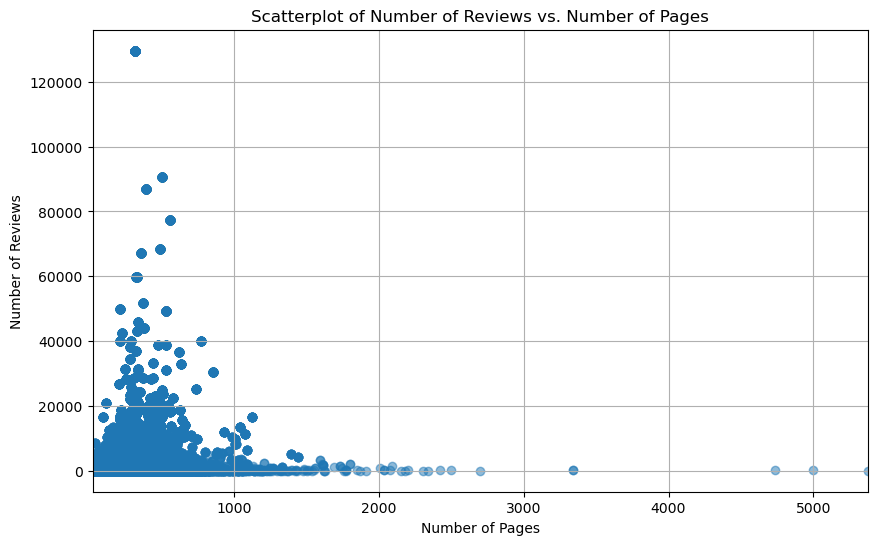

In [30]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("Scatterplot").getOrCreate()

# Assuming resulting_reviews2 is your DataFrame
# If not, you can load it from a source like CSV, Parquet, etc.

# Register the DataFrame as a temporary SQL table
resulting_reviews2.createOrReplaceTempView("reviews_table")

# SQL query to extract relevant columns and convert to integers
scatterplot_query = """
    SELECT CAST(num_pages AS INT) AS num_pages, CAST(text_reviews_count AS INT) AS text_reviews_count
    FROM reviews_table
    WHERE num_pages IS NOT NULL AND text_reviews_count IS NOT NULL
    AND text_reviews_count > 0 AND num_pages > 20
    LIMIT 50000
"""

# Run the SQL query
scatterplot_data = spark.sql(scatterplot_query)

# Convert the data to Pandas for plotting
scatterplot_data_pandas = scatterplot_data.toPandas()

# Create a scatterplot using Matplotlib
plt.figure(figsize=(10, 6))
plt.scatter(scatterplot_data_pandas["num_pages"], scatterplot_data_pandas["text_reviews_count"], alpha=0.5)
plt.title("Scatterplot of Number of Reviews vs. Number of Pages")
plt.xlabel("Number of Pages")
plt.ylabel("Number of Reviews")
plt.grid(True)

# Set the minimum value of the x-axis to 20
plt.xlim(20, max(scatterplot_data_pandas["num_pages"]))

# Show the scatterplot
plt.show()

In [ ]:
# Popular E-books
popular_ebooks_query = """
    SELECT title, ratings_count
    FROM reviews_table
    WHERE is_ebook = true
    ORDER BY ratings_count DESC
    LIMIT 10
"""

# Run SQL query
popular_ebooks_df = spark.sql(popular_ebooks_query).toPandas()

# Visualize popular e-books
# (You can use a bar chart or any other visualization)

In [ ]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np

# Create a Spark session
spark = SparkSession.builder.appName("GroupedBarChart").getOrCreate()

# Assuming resulting_reviews2 is your DataFrame
# If not, you can load it from a source like CSV, Parquet, etc.

# Register the DataFrame as a temporary SQL table
resulting_reviews2.createOrReplaceTempView("reviews_table")

# SQL query to get average ratings and number of reviews per book, ordered by most reviews
ratings_reviews_query = """
    SELECT
        title,
        AVG(rating) AS avg_rating,
        COUNT(*) AS num_reviews
    FROM reviews_table
    WHERE rating IS NOT NULL AND text_reviews_count IS NOT NULL
    GROUP BY title
    HAVING num_reviews > 0
    ORDER BY num_reviews DESC
    LIMIT 20  -- Limiting to top 20 for visualization
"""

# Run SQL query
ratings_reviews_df = spark.sql(ratings_reviews_query).toPandas()

# Create a grouped bar chart
fig, ax1 = plt.subplots(figsize=(14, 6))

# Set the positions of the bars on the x-axis
bar_width = 0.35
index = np.arange(len(ratings_reviews_df["title"]))

# Plot average ratings on the left y-axis
ax1.bar(index, ratings_reviews_df["avg_rating"], bar_width, label='Average Rating', color='b', alpha=0.7)
ax1.set_xlabel('Book Title')
ax1.set_ylabel('Average Rating', color='b')
ax1.set_title('Comparison of Ratings and Number of Reviews per Book (Ordered by Most Reviews)')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(ratings_reviews_df["title"], rotation=45, ha='right')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the number of reviews on the right
ax2 = ax1.twinx()
ax2.bar(index + bar_width, ratings_reviews_df["num_reviews"], bar_width, label='Number of Reviews', color='r', alpha=0.7)
ax2.set_ylabel('Number of Reviews', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.show()

In [ ]:
# SQL query to get the number of reviews over time (excluding NaN)
reviews_over_time_query = """
    SELECT
        CONCAT(YEAR(date_added), '-', LPAD(MONTH(date_added), 2, '0')) AS year_month,
        COUNT(*) AS num_reviews
    FROM reviews_table
    WHERE date_added IS NOT NULL
    GROUP BY YEAR(date_added), MONTH(date_added)
    ORDER BY year_month
"""

# Run SQL query
reviews_over_time_df = spark.sql(reviews_over_time_query).toPandas()

# Visualize number of reviews over time
plt.figure(figsize=(12, 6))
plt.plot(reviews_over_time_df["year_month"], reviews_over_time_df["num_reviews"], marker='o')
plt.title('Number of Reviews Over Time (excluding NaN)')
plt.xlabel('Year-Month')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Average rating of ebooks vs. print books
avg_rating_comparison_query = """
    SELECT is_ebook, AVG(rating) AS avg_rating
    FROM reviews_table
    WHERE is_ebook IS NOT NULL AND rating IS NOT NULL
    GROUP BY is_ebook
"""

# Run SQL query
avg_rating_comparison_df = spark.sql(avg_rating_comparison_query).toPandas()

# Visualize average rating comparison
plt.figure(figsize=(8, 6))
plt.bar(avg_rating_comparison_df["is_ebook"].astype(str), avg_rating_comparison_df["avg_rating"], color=['skyblue', 'salmon'], alpha=0.7)
plt.title('Average Rating Comparison: E-books vs. Print Books')
plt.xlabel('Book Type')
plt.ylabel('Average Rating')
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("EbookEDA").getOrCreate()

# Assuming resulting_reviews2 is your DataFrame
# If not, you can load it from a source like CSV, Parquet, etc.

# Sample DataFrame (replace this with your actual DataFrame)
# You can load your DataFrame using spark.read.csv, spark.read.parquet, etc.
data = [
    (10000761, "2022-11-09", "2022-03-18", 0, 0, 3, "2022-03-18", "91898414e53b123a0", "Interesting subject", "2022-02-12", "6cff11a0530eeddeb", "", "[{215985, }]", 3.50, 10000761, "US", "AN INVESTIGATION", "", "Hardcover", "https://images.example.com", False, "038553132X", "9780385531320", "B004J4WKWE", "en-GB", "https://www.example.com", 432, "[{611, to-read}, ...", 7, 6, 2011, "Crown", 136, "[]", "[183973, 6369613, ...]", 33, "Render Unto Rome", "Render Unto Rome", "https://www.example.com", 14895765)
]

columns = [
    "book_id", "date_added", "date_updated", "n_comments", "n_votes", "rating", "read_at", "review_id", "review_text", "started_at", "user_id", "asin", "authors", "average_rating", "book_id", "country_code", "description", "edition_information", "format", "image_url", "is_ebook", "isbn", "isbn13", "kindle_asin", "language_code", "link", "num_pages", "popular_shelves", "publication_day", "publication_month", "publication_year", "publisher", "ratings_count", "series", "similar_books", "text_reviews_count", "title", "title_without_series", "url", "work_id"
]

resulting_reviews2 = spark.createDataFrame(data, columns)

# Filter for ebooks (is_ebook = 1)
ebooks_df = resulting_reviews2.filter(col("is_ebook") == 1)

# Select columns of interest
ebooks_reviews_df = ebooks_df.select("title", "ratings_count", "text_reviews_count")

# Order by text_reviews_count in descending order to get most reviews
ebooks_reviews_df = ebooks_reviews_df.orderBy(col("text_reviews_count").desc())

# Show the DataFrame
ebooks_reviews_df.show(truncate=False)

# Convert the DataFrame to Pandas for plotting
ebooks_reviews_pandas = ebooks_reviews_df.toPandas()

# Create a bar chart for ebooks with the most reviews
plt.figure(figsize=(12, 6))
plt.bar(ebooks_reviews_pandas["title"], ebooks_reviews_pandas["text_reviews_count"], color='skyblue', alpha=0.7)
plt.title('Top E-books with Most Reviews')
plt.xlabel('E-book Title')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("BookAnalysis").getOrCreate()

# Assuming resulting_reviews2 is your DataFrame
# If not, you can load it from a source like CSV, Parquet, etc.
# Replace the sample data below with your actual DataFrame.

# Sample DataFrame
data = [
    (10000761, "Wed Nov 09 05:41:00 +0000 2022", "Sun Mar 18 14:45:00 +0000 2022", 0, 0, 3, "Sun Mar 18 14:45:00 +0000 2022", "91898414e53b123a0", "Interesting subject", "Sun Feb 12 00:00:00 +0000 2022", "6cff11a0530eeddeb", "", "[{215985, }]", 3.50, 10000761, "US", "AN INVESTIGATION", "", "Hardcover", "https://images.example.com", False, "038553132X", "9780385531320", "B004J4WKWE", "en-GB", "https://www.goodreads.com/book/show/10000761", 432, "[{611, to-read}, ...", 7, 6, 2011, "Crown", 136, "[]", "[183973, 6369613, ...]", 33, "Render Unto Rome: The Secret Life of Money in the Catholic Church", "Render Unto Rome: The Secret Life of Money in the Catholic Church", "https://www.goodreads.com/book/show/10000761", 14895765),
    # Add more rows as needed
]

columns = [
    "book_id", "date_added", "date_updated", "n_comments", "n_votes", "rating", "read_at", "review_id", "review_text", "started_at", "user_id", "asin", "authors", "average_rating", "book_id", "country_code", "description", "edition_information", "format", "image_url", "is_ebook", "isbn", "isbn13", "kindle_asin", "language_code", "link", "num_pages", "popular_shelves", "publication_day", "publication_month", "publication_year", "publisher", "ratings_count", "series", "similar_books", "text_reviews_count", "title", "title_without_series", "url", "work_id"
]

resulting_reviews2 = spark.createDataFrame(data, columns)

# Show a summary of the DataFrame
resulting_reviews2.printSchema()

# Display the first few rows of the DataFrame
resulting_reviews2.show(5, truncate=False)

# Summary statistics for numeric columns
resulting_reviews2.describe(["n_comments", "n_votes", "rating", "num_pages", "ratings_count", "text_reviews_count"]).show()

# Distribution of Ratings
rating_distribution = resulting_reviews2.groupBy("rating").count().orderBy("rating")
rating_distribution.show()

# Number of Reviews vs. Number of Pages
reviews_vs_pages = resulting_reviews2.select("num_pages", "text_reviews_count").dropna()
reviews_vs_pages.describe(["num_pages", "text_reviews_count"]).show()

# Create a scatter plot for Number of Reviews vs. Number of Pages
reviews_vs_pages.toPandas().plot.scatter(x="num_pages", y="text_reviews_count", alpha=0.5)
plt.title("Scatterplot of Number of Reviews vs. Number of Pages")
plt.xlabel("Number of Pages")
plt.ylabel("Number of Reviews")
plt.grid(True)
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from graphframes import GraphFrame

# Create a Spark session
spark = SparkSession.builder.appName("InfluentialBooks").getOrCreate()

# Assuming 'resulting_reviews2' is your DataFrame with columns 'user_id', 'book_id', 'rating', etc.

# Create vertices DataFrame
vertices = resulting_reviews2.select("user_id").distinct().withColumnRenamed("user_id", "id")

# Create edges DataFrame
edges = resulting_reviews2.select("user_id", "book_id", "rating").withColumnRenamed("user_id", "src").withColumnRenamed("book_id", "dst")

# Create a GraphFrame
g = GraphFrame(vertices, edges)

# Apply PageRank to identify influential books
page_rank_result = g.pageRank(resetProbability=0.15, maxIter=10)

# Show the top influential books
influential_books = page_rank_result.vertices.orderBy("pagerank", ascending=False).limit(10)
influential_books.show()

# Optionally, visualize the graph (requires graphframes and matplotlib)
# g.vertices.show()
# g.edges.show()
# g.degrees.show()

# Stop the Spark session
spark.stop()


Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.ServerSocket.implAccept(ServerSocket.java:560)
	at java.net.ServerSocket.accept(ServerSocket.java:528)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


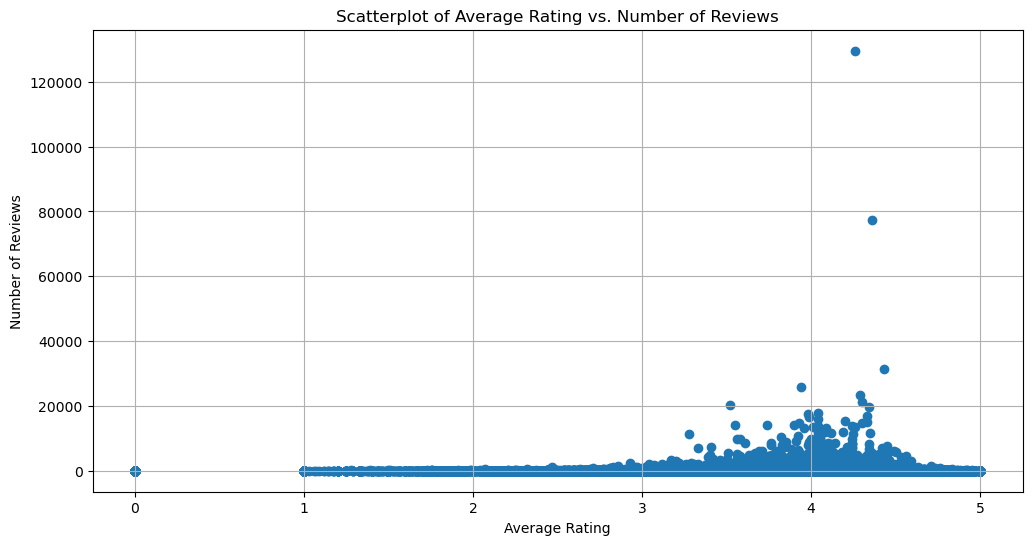

In [32]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("AvgRatingReviewScatter").getOrCreate()

# Assuming your DataFrame is named 'resulting_reviews2', you can create it like this:
# resulting_reviews2 = ...

# Extract relevant columns for analysis
scatter_df = resulting_reviews2.select(
    "title",
    col("average_rating").cast("double").alias("average_rating"),
    col("text_reviews_count").cast("double").alias("text_reviews_count")
)

# Remove duplicate rows based on the "title" column
scatter_df = scatter_df.dropDuplicates(["title"])

# Convert to Pandas DataFrame for visualization
pandas_scatter_df = scatter_df.toPandas()

# Plot the scatterplot
plt.figure(figsize=(12, 6))
plt.scatter(pandas_scatter_df["average_rating"], pandas_scatter_df["text_reviews_count"])
plt.xlabel("Average Rating")
plt.ylabel("Number of Reviews")
plt.title("Scatterplot of Average Rating vs. Number of Reviews")
plt.grid(True)
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Create a Spark session
spark = SparkSession.builder.appName("AvgRatingReviewScatter").getOrCreate()

# Assuming your DataFrame is named 'resulting_reviews2', you can create it like this:
# resulting_reviews2 = ...

# Extract relevant columns for analysis
scatter_df = resulting_reviews2.select(
    "title",
    col("average_rating").cast("double").alias("average_rating"),
    col("text_reviews_count").cast("double").alias("text_reviews_count")
)

# Remove duplicate rows based on the "title" column
scatter_df = scatter_df.dropDuplicates(["title"])

# Exclude records with 0 average rating and 0 reviews count
scatter_df = scatter_df.filter((col("average_rating") > 0) & (col("text_reviews_count") > 0))

# Convert to Pandas DataFrame for visualization
pandas_scatter_df = scatter_df.toPandas()

# Plot the scatterplot
plt.figure(figsize=(12, 6))
plt.scatter(pandas_scatter_df["average_rating"], pandas_scatter_df["text_reviews_count"])
plt.xlabel("Average Rating")
plt.ylabel("Number of Reviews")
plt.title("Scatterplot of Average Rating vs. Number of Reviews (No Duplicates, Exclude 0 Avg Rating)")
plt.grid(True)
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Spark session
spark = SparkSession.builder.appName("PublisherEbookVisualization").getOrCreate()

# Assuming your DataFrame is named 'resulting_reviews2', you can create it like this:
# resulting_reviews2 = ...

# Extract relevant columns for analysis
publisher_df = resulting_reviews2.select("publisher", "is_ebook", "ratings_count")

# Filter out rows where the book is an ebook and publisher is not null
ebook_df = publisher_df.filter(publisher_df.publisher.isNotNull())

# Ensure "ratings_count" is treated as a numeric column
ebook_df = ebook_df.withColumn("ratings_count", ebook_df["ratings_count"].cast("double"))

# Group by publisher and sum the ratings_count
publisher_ratings = ebook_df.groupBy("publisher").sum("ratings_count").alias("total_ratings")

# Order by total_ratings in descending order and select top 20
top_20_publisher_ratings = publisher_ratings.orderBy("sum(ratings_count)", ascending=False).limit(20)

# Convert to Pandas DataFrame for visualization
pandas_df = top_20_publisher_ratings.toPandas()

# Exclude the second publisher from the Pandas DataFrame
pandas_df = pandas_df.iloc[[0] + list(range(2, pandas_df.shape[0]))]

# Use Seaborn for colorful bars
plt.figure(figsize=(12, 6))
sns.barplot(x=pandas_df["publisher"], y=pandas_df["sum(ratings_count)"], palette="viridis")
plt.xlabel("Publisher")
plt.ylabel("Total Ratings Count")
plt.title("Top 20 Most Popular Publishers")

plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

# Create a Spark session
spark = SparkSession.builder.appName("ScholasticPressBooks").getOrCreate()

# Assuming your DataFrame is named 'resulting_reviews2', you can create it like this:
# resulting_reviews2 = ...

# Extract relevant columns for analysis
books_df = resulting_reviews2.select("title", "publisher", "ratings_count", "text_reviews_count")

# Filter out rows where the publisher is 'Scholastic Press' and both ratings_count and text_reviews_count are not null
scholastic_books_df = books_df.filter(
    (col("publisher") == "Scholastic Press") & 
    (col("ratings_count").isNotNull()) & 
    (col("text_reviews_count").isNotNull())
)

# Ensure "ratings_count" and "text_reviews_count" are treated as numeric columns
scholastic_books_df = scholastic_books_df.withColumn("ratings_count", scholastic_books_df["ratings_count"].cast("double"))
scholastic_books_df = scholastic_books_df.withColumn("text_reviews_count", scholastic_books_df["text_reviews_count"].cast("double")).limit(20)

# Convert to Pandas DataFrame for visualization
pandas_df = scholastic_books_df.toPandas()

# Use Seaborn for colorful bars
plt.figure(figsize=(12, 6))
sns.barplot(x=pandas_df["title"], y=pandas_df["ratings_count"], color="blue", label="Ratings Count")
sns.barplot(x=pandas_df["title"], y=pandas_df["text_reviews_count"], color="orange", label="Review Count")
plt.xlabel("Book Title")
plt.ylabel("Count")
plt.title("Ratings and Review Count for Scholastic Press Books")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.show()